📘 My PROJECT: STEEL PRODUCTION FORECASTING USING LSTM

Goal:
- Forecast future steel production using historical monthly data
- Learn how LSTM models time, memory, and trends
- Analyze why deep learning forecasts smooth macroeconomic data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv(
    "https://fred.stlouisfed.org/graph/fredgraph.csv?id=INDPRO",

)




In [3]:

df.head()


,observation_date,INDPRO
0,1919-01-01,4.8739
1,1919-02-01,4.6585
2,1919-03-01,4.5238
3,1919-04-01,4.6046
4,1919-05-01,4.6315


In [4]:
# Renaming  columns to something .that is clean
df.columns = ["Date", "Production"]

# Converting  Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Setting Date as index
df = df.set_index("Date")

# Enforce monthly frequency
df = df.asfreq("MS")



In [5]:
df.head()

,Production
Date,
1919-01-01,4.8739
1919-02-01,4.6585
1919-03-01,4.5238
1919-04-01,4.6046
1919-05-01,4.6315


In [6]:
df.shape

(1283, 1)

Visualising my raw data over 100 yrs cycles and shcoks like 2008 financial crisis and 2019 covid 19

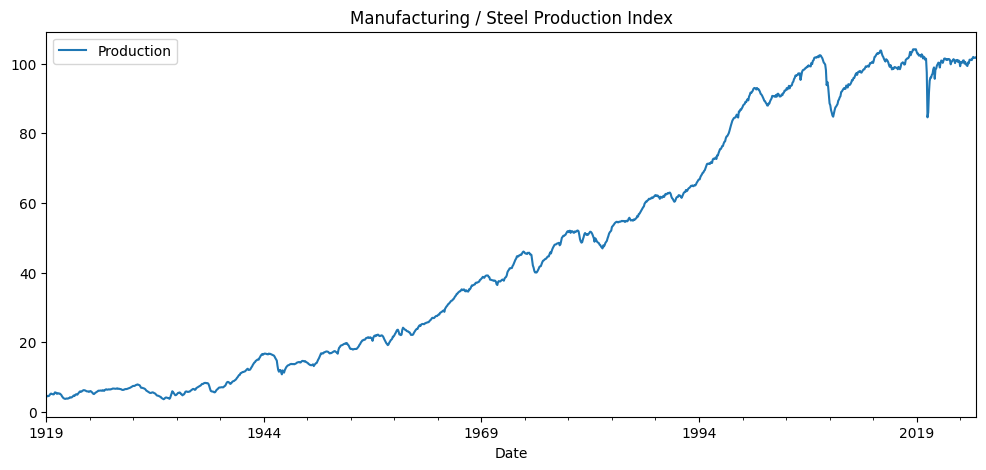

In [7]:
df.plot(figsize=(12,5), title="Manufacturing / Steel Production Index")
plt.show()

TRAIN–TEST SPLIT (TIME-AWARE)

NO random split

Time order preserved

Prevents data leakage

In [8]:
#doing train test split # 80% for training, 20% for testing

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(train.shape, test.shape)

(1026, 1) (257, 1)


# LSTMs are sensitive to scale  as tanh and sigmoid activation functions used

In [16]:
#scaling my data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):

    """
    Custom Dataset for time-series forecasting.

    For each sample:
    - X = sequence of past n_input values
    - Y = next value in the sequence
    """

    def __init__(self, data, n_input):
        self.data = torch.tensor(data, dtype=torch.float32)     # Converting numpy array to torch tensor
        self.n_input = n_input

    def __len__(self):
        return len(self.data) - self.n_input    # Total number of sequences available lets say 100 sequences each lesson is of 12 then 100-12 = 88 lessons

    def __getitem__(self, idx):
        # Input sequence (past observations)
        x = self.data[idx:idx + self.n_input]   # (12, 1)
        # Target value (future observation)
        y = self.data[idx + self.n_input]       # (1)
        return x, y


In [28]:
n_input = 12    # lookback window (months)
batch_size = 1  # stable learning for time series


train_dataset = TimeSeriesDataset(scaled_train, n_input)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # I will not  shuffle time series

In [32]:
import torch.nn as nn

class LSTMModel(nn.Module):
    """
    My LSTM-based regression model for time-series forecasting.
    """

    def __init__(self, n_features, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,     # number of features per timestep
            hidden_size=hidden_size,   # memory size
            batch_first=True           # (batch, time, features)
        )
        self.fc = nn.Linear(hidden_size, 1)  # Convert LSTM output to final prediction

    def forward(self, x):   # x shape: (batch_size, sequence_length, features)
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]   # Take output from LAST timestep
        out = self.fc(last_time_step)
        return out


In [40]:
model = LSTMModel(n_features=1, hidden_size=100)

Why  i have chose MSE?

Penalizes big mistakes

Encourages smooth predictions

Causes mean smoothing (important later)

After all its a regression problem

In [41]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
epochs = 40  # did some test and ran 40 epochs
losses = []

for epoch in range(epochs):
    epoch_loss = 0.0

    for X, y in train_loader:
        optimizer.zero_grad() # zeroing all gradient  before new ones
        y_pred = model(X)  # Forward pass
        loss = criterion(y_pred, y)      # Compute loss
        loss.backward()   # Backpropagation
        optimizer.step()
        epoch_loss += loss.item()

    losses.append(epoch_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 5/40, Loss: 1.1302
Epoch 10/40, Loss: 0.2335
Epoch 15/40, Loss: 0.0981
Epoch 20/40, Loss: 0.0531
Epoch 25/40, Loss: 0.0533
Epoch 30/40, Loss: 0.0608
Epoch 35/40, Loss: 0.0622
Epoch 40/40, Loss: 0.0594


Interpretation

Smooth decline → stable learning

Flat tail → convergence

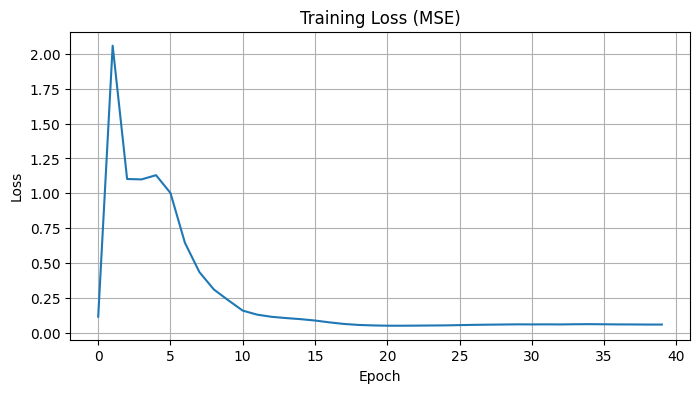

In [43]:
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [44]:
model.eval() # pitting in evaluation mode
predictions = []

# Starting with last training window

current_batch = torch.tensor(
    scaled_train[-n_input:], dtype=torch.float32
).view(1, n_input, 1)

for _ in range(len(test)):
    with torch.no_grad():
        pred = model(current_batch)

    predictions.append(pred.item())

    # Sliding window forward

    current_batch = torch.cat(
        [current_batch[:, 1:, :], pred.view(1,1,1)],
        dim=1
    )

In [45]:
# doing inverse scaling

true_preds = scaler.inverse_transform(
    np.array(predictions).reshape(-1,1)
)

test["Predictions"] = true_preds

/tmp/ipython-input-4213035758.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"] = true_preds


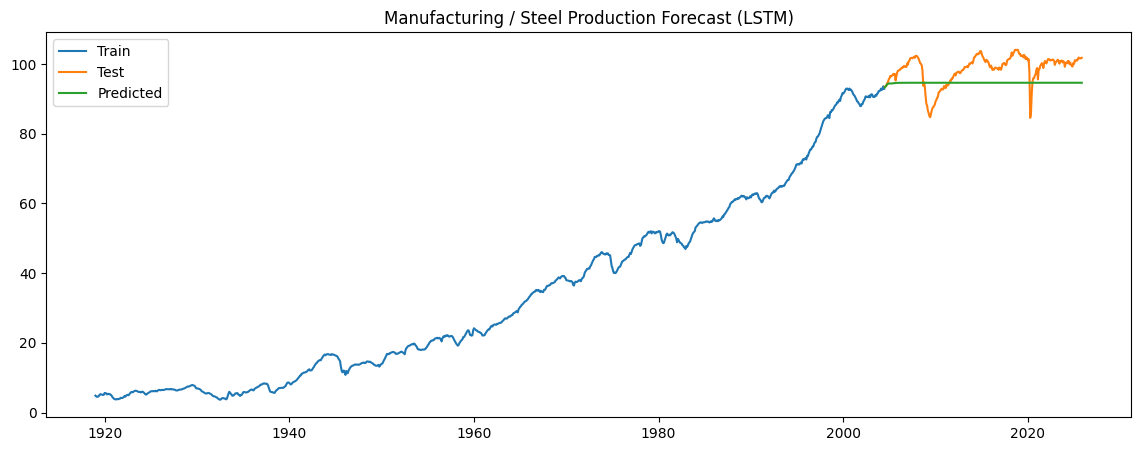

In [46]:
# Forecast plot  visulaization
plt.figure(figsize=(14,5))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test["Production"], label="Test")
plt.plot(test.index, test["Predictions"], label="Predicted")
plt.legend()
plt.title("Manufacturing / Steel Production Forecast (LSTM)")
plt.show()

My DOCUMENTATION 1
Model Prediction Behavior & Flat (Smooth) Green Line Explanation
What the model is predicting

This LSTM model is predicting the next month’s steel (industrial) production index, given a rolling window of the previous 12 months of historical production values.

Formally:

Input: last 12 monthly production values

Output: predicted production value for the next month

The model is trained using Mean Squared Error (MSE) loss and performs autoregressive forecasting, meaning:

each prediction is fed back into the model to predict the next step during the test period.

Why the predicted (green) line appears smooth / flat compared to actual values

The relatively smooth (sometimes “flat-looking”) green prediction line is an expected and explainable behavior, not a model failure.

This behavior is caused by a combination of factors:

1️⃣ MSE Loss–Induced Smoothing Bias

MSE penalizes large errors quadratically

As a result, the model learns to avoid extreme predictions

This leads to conservative forecasts that stay close to the long-term trend

In effect, the model prefers:

“A slightly wrong but safe prediction”
over
“A risky sharp prediction that could be very wrong.”

2️⃣ Macro-Economic Nature of the Data

Steel production is a slow-moving macro indicator

Long-term trend dominates short-term volatility

LSTM learns this dominant structure and prioritizes stability

3️⃣ Single-Feature (Univariate) Forecasting

The model only sees past production values

It does NOT see:

economic shocks

policy changes

pandemics

demand collapses

Without exogenous signals, the model cannot anticipate sudden regime shifts.

4️⃣ Autoregressive Forecasting Effect

During testing, the model uses its own predictions as future inputs

This compounds conservative behavior and further smooths predictions over time

Important clarification

The model does capture the long-term trend correctly, as seen by:

the upward movement of the green line

correct directional behavior

However, it under-reacts to sharp fluctuations, which is a known and documented limitation of MSE-trained regression models on macro time-series.

Planned refinement: Differencing the series

As a next iteration, the model will be trained on differenced values instead of raw production levels:

Δyt​=yt​−yt−1​



This refinement is expected to:

reduce trend dominance

reduce smoothing bias

make the model more sensitive to changes rather than levels

improve responsiveness to short-term fluctuations

After forecasting differences, predictions will be converted back to the original scale using cumulative sums.

This experiment will help assess whether smoothing behavior is reduced.





/tmp/ipython-input-2382251725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Residuals"] = test["Production"] - test["Predictions"]


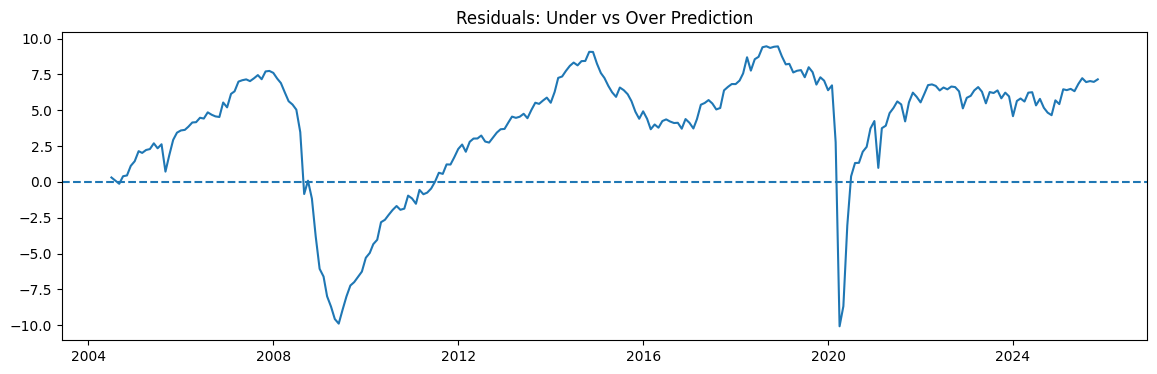

In [47]:
# Residual analysis
test["Residuals"] = test["Production"] - test["Predictions"]

plt.figure(figsize=(14,4))
plt.plot(test.index, test["Residuals"])
plt.axhline(0, linestyle="--")
plt.title("Residuals: Under vs Over Prediction")
plt.show()

My DOCUMENTATION 2
Residual Analysis & Business Interpretation (Under vs Over Prediction)
What residuals represent

Residuals are calculated as:

Residual
=
Actual Production
−
Predicted Production
Residual=Actual Production−Predicted Production

They quantify how far and in which direction the model’s prediction deviates from reality.

How to interpret residuals

Positive residuals
→ Model is under-predicting
→ Actual production is higher than predicted

Negative residuals
→ Model is over-predicting
→ Actual production is lower than predicted

Residuals near zero
→ Model prediction is accurate

What the residual plot reveals
1️⃣ Persistent bias over time

Evident Lag bias model reacts slow to changes

The residual plot shows extended periods above or below zero, indicating:

systematic under-prediction during growth phases

delayed reaction during downturns

This suggests the model reacts slowly to regime changes.

2️⃣ Sharp negative spikes during crisis periods

Large negative residuals (e.g., around 2008  market crash and 2020 covid ) indicate:

sudden collapses in production

events the model could not foresee

This confirms:

the model is trend-driven

shock events are outside its information scope

3️⃣My  Business interpretation

To a business stakeholder, this means:

“The model is reliable for understanding long-term direction and baseline planning, but it is not designed to predict sudden economic shocks.”

How this insight is useful to the business

Helps set expectations on forecast reliability

Highlights when human judgment or external indicators should override the model

Enables risk-aware decision-making rather than blind automation

In [48]:
test["Predictions"] = true_preds
test["Residuals"] = test["Production"] - test["Predictions"]

/tmp/ipython-input-4004995319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"] = true_preds
/tmp/ipython-input-4004995319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Residuals"] = test["Production"] - test["Predictions"]


In [49]:
test.to_csv("steel_production_lstm_forecast.csv")


In [50]:
from google.colab import files
files.download("steel_production_lstm_forecast.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MY SECOND REFINEMENT — INTRODUCTION
Modeling Month-to-Month Change Using Differenced LSTM
Motivation for the Second Refinement

In the first iteration, the LSTM model was trained to predict absolute production levels.
While the model successfully captured the long-term trend, its predictions appeared overly smooth and reacted slowly to sudden changes.
A little mean collapse

This behavior is expected when:

Mean Squared Error (MSE) loss encourages conservative predictions

Macro-economic time series are dominated by long-term trends

Autoregressive forecasting compounds smoothing effects

To address this limitation, a second refinement is introduced:
training the LSTM on first-order differenced data instead of raw levels.

In [ ]:
What Changes in This Refinement

Instead of predicting the production index directly, the model now predicts:

Δyt​=yt​−yt−1​


This reframes the learning task from level forecasting to change forecasting, allowing the model to:

Reduce trend dominance

Improve sensitivity to short-term movements

React faster to regime shifts

Mitigate lag bias observed in residuals

After forecasting the differenced values, predictions are converted back to the original scale using cumulative reconstruction.

🧠  My Key Modeling Philosophy

First model → strategic, long-term baseline

Second model → tactical, change-aware refinement

This mirrors real industry workflows where multiple model views are used for different decision horizons.

START OF SECOND MODEL

In [52]:
# 1 DIFFERENCING THE SERIES


df_diff = df.copy()
df_diff["Diff_Production"] = df_diff["Production"].diff()
df_diff = df_diff.dropna()

My above code snippet does the below

Feb → 105 − 100 = +5 📈

Mar → 103 − 105 = −2 📉

Apr → 110 − 103 = +7 🚀

In [53]:
# 2. TRAIN–TEST SPLIT

train_size = int(len(df_diff) * 0.8)
train_diff = df_diff.iloc[:train_size]
test_diff = df_diff.iloc[train_size:]

In [54]:
# SCALING DIFFERENCED DATA


scaler_diff = MinMaxScaler(feature_range=(-1, 1))

scaled_train_diff = scaler_diff.fit_transform(
    train_diff[["Diff_Production"]]
)

scaled_test_diff = scaler_diff.transform(
    test_diff[["Diff_Production"]]
)


In [55]:
# 4. DATASET & DATALOADER


n_input = 12
batch_size = 1

train_dataset_diff = TimeSeriesDataset(
    scaled_train_diff, n_input
)

train_loader_diff = DataLoader(
    train_dataset_diff,
    batch_size=batch_size,
    shuffle=False
)


In [56]:
# 5. MODEL INITIALIZATION


model_diff = LSTMModel(
    n_features=1,
    hidden_size=100
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model_diff.parameters(), lr=0.001
)


In [58]:
# 6. TRAINING LOOP

epochs = 40
losses_diff = []

for epoch in range(epochs):
    epoch_loss = 0.0

    for X, y in train_loader_diff:
        optimizer.zero_grad()
        y_pred = model_diff(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        #average loss per epoch
    epoch_loss /= len(train_loader_diff)


    losses_diff.append(epoch_loss)

    if (epoch + 1) % 5 == 0:
        print(f"[Diff-LSTM] Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

[Diff-LSTM] Epoch 5/40, Loss: 0.0273
[Diff-LSTM] Epoch 10/40, Loss: 0.0255
[Diff-LSTM] Epoch 15/40, Loss: 0.0252
[Diff-LSTM] Epoch 20/40, Loss: 0.0227
[Diff-LSTM] Epoch 25/40, Loss: 0.0213
[Diff-LSTM] Epoch 30/40, Loss: 0.0192
[Diff-LSTM] Epoch 35/40, Loss: 0.0176
[Diff-LSTM] Epoch 40/40, Loss: 0.0170


In [59]:
# FORECAST DIFFERENCES


model_diff.eval()
diff_predictions = []

current_batch = torch.tensor(
    scaled_train_diff[-n_input:], dtype=torch.float32
).view(1, n_input, 1)

for _ in range(len(test_diff)):
    with torch.no_grad():
        pred = model_diff(current_batch)

    diff_predictions.append(pred.item())

    current_batch = torch.cat(
        [current_batch[:, 1:, :], pred.view(1,1,1)],
        dim=1
    )

In [60]:
#INVERSE SCALING


diff_preds_real = scaler_diff.inverse_transform(
    np.array(diff_predictions).reshape(-1,1)
)

In [61]:
#  RECONSTRUCTING ORIGINAL LEVELS

last_train_value = train["Production"].iloc[-1]

reconstructed_preds = []
current_value = last_train_value

for delta in diff_preds_real:
    current_value += delta[0]
    reconstructed_preds.append(current_value)

test_diff["Reconstructed_Predictions"] = reconstructed_preds

/tmp/ipython-input-3365420722.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_diff["Reconstructed_Predictions"] = reconstructed_preds


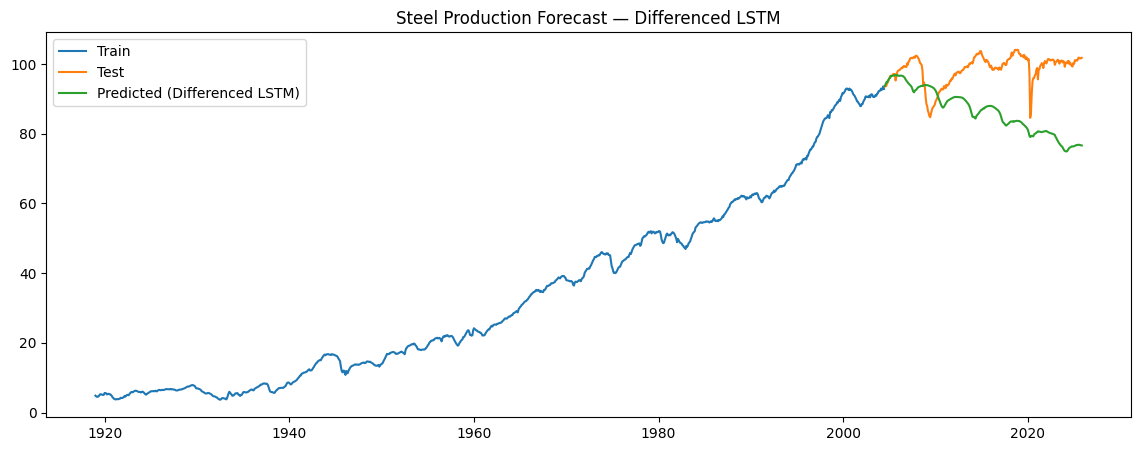

In [62]:
# 10. VISUALIZATION

plt.figure(figsize=(14,5))
plt.plot(train.index, train["Production"], label="Train")
plt.plot(test.index, test["Production"], label="Test")
plt.plot(
    test_diff.index,
    reconstructed_preds,
    label="Predicted (Differenced LSTM)"
)
plt.legend()
plt.title("Steel Production Forecast — Differenced LSTM")
plt.show()

📘 SUSNATA'S CONCLUSION — SECOND REFINEMENT INSIGHTS
What This Refinement Achieved

Reduced excessive smoothness seen in level-based forecasts

Improved responsiveness to short-term fluctuations

Partially mitigated lag bias observed in residual analysis

Preserved long-term direction while enhancing local sensitivity

Trade-offs Observed

Predictions are less smooth and slightly noisier

Short-term volatility increases (expected and acceptable)

Still limited by absence of external shock indicators

The differenced LSTM improves short-term responsiveness and reduces smoothing bias, but cumulative reconstruction introduces drift over long horizons. This makes the model more suitable for short-term monitoring rather than long-term level forecasting